In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/WSN-DS.csv'
data = pd.read_csv(file_path)

In [ ]:
# Drop 115,000 rows with 'Normal' attack type
normal_rows = data[data['Attack type'] == 'Normal']
drop_rows = normal_rows.sample(n=115000, random_state=42)
data = data.drop(drop_rows.index)

# Encode labels
label_encoder = LabelEncoder()
data['Attack type'] = label_encoder.fit_transform(data['Attack type'])

# Separate features and labels
X = data.drop(columns=['Attack type'])
y = data['Attack type']

# Convert the features to text format (assuming the features are numerical and need conversion)
X_text = X.astype(str).apply(lambda x: ' '.join(x), axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
def tokenize_data(data):
    return tokenizer(
        data.tolist(),
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Tokenize the training and test sets
X_train_tokens = tokenize_data(X_train)
X_test_tokens = tokenize_data(X_test)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train_tokens['input_ids'], X_train_tokens['attention_mask'], y_train_tensor)
test_dataset = TensorDataset(X_test_tokens['input_ids'], X_test_tokens['attention_mask'], y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Load the BERT model for multiclass classification
teacher_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
teacher_model.to(device)

# Define the optimizer
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=2e-5)

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop for the teacher model (BERT)
num_epochs = 3
train_losses = []
val_losses = []

teacher_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = teacher_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    teacher_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = teacher_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

Epoch 1, Train Loss: 0.05570631059004058, Validation Loss: 0.02867830785441695
Epoch 2, Train Loss: 0.029250766130316772, Validation Loss: 0.02436671828913077
Epoch 3, Train Loss: 0.023478435342194532, Validation Loss: 0.024798320396365776


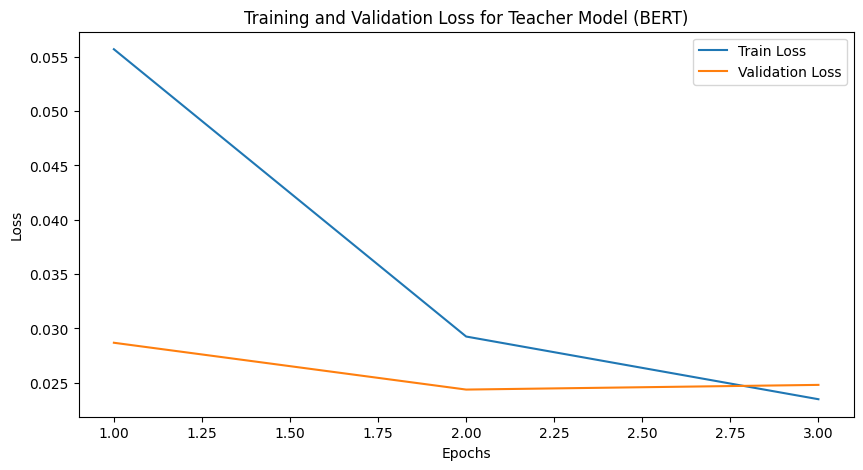

In [ ]:
# Plotting the loss for the teacher model
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Teacher Model (BERT)')
plt.legend()
plt.show()

In [ ]:
# Load the DistilBERT model for multiclass classification
student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))
student_model.to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
num_epochs = 3
train_losses = []
val_losses = []

# Define the distillation loss
def distillation_loss(student_outputs, teacher_outputs, labels, temperature=2.0, alpha=0.5):
    student_loss = F.cross_entropy(student_outputs.logits, labels)
    teacher_probs = F.softmax(teacher_outputs.logits / temperature, dim=-1)
    student_log_probs = F.log_softmax(student_outputs.logits / temperature, dim=-1)
    distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (temperature ** 2)
    return alpha * student_loss + (1 - alpha) * distillation_loss

# Training loop for the student model (DistilBERT)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=2e-5)
student_model.train()

distil_train_losses = []
distil_val_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids, attention_mask=attention_mask)
        student_outputs = student_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = distillation_loss(student_outputs, teacher_outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    distil_train_losses.append(avg_train_loss)

    # Validation loss
    student_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            student_outputs = student_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = student_outputs.loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)
    distil_val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')


Epoch 1, Train Loss: 0.3319652463170805, Validation Loss: 0.4164536524740767
Epoch 2, Train Loss: 0.32575918443579616, Validation Loss: 0.4095674414033884
Epoch 3, Train Loss: 0.32523549662196083, Validation Loss: 0.4117944125437252


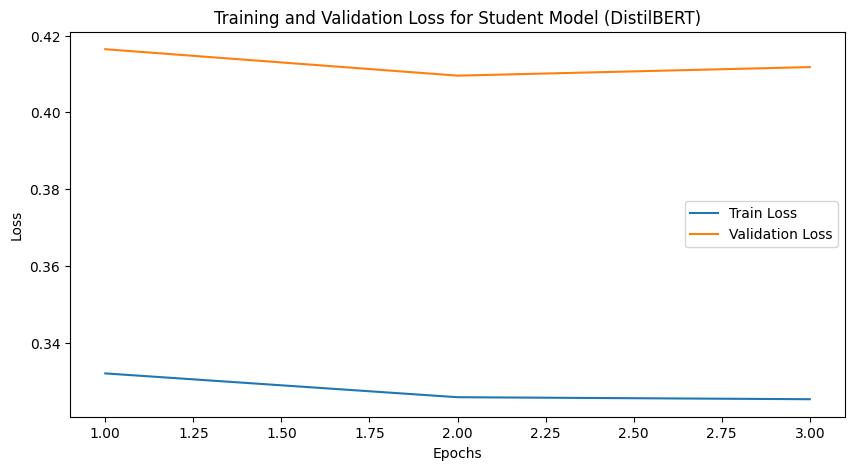

In [ ]:
# Plotting the loss for the student model
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), distil_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), distil_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Student Model (DistilBERT)')
plt.legend()
plt.show()

In [ ]:
# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).tolist())
            true_labels.extend(labels.tolist())
    return true_labels, preds

In [ ]:
# Evaluate the teacher model
y_true, y_pred = evaluate(teacher_model, test_loader)
teacher_acc = accuracy_score(y_true, y_pred)
teacher_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(f'Teacher Model Accuracy: {teacher_acc}')
print(f'Teacher Model Classification Report:\n{teacher_report}')

# Evaluate the student model
y_true, y_pred = evaluate(student_model, test_loader)
student_acc = accuracy_score(y_true, y_pred)
student_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(f'Student Model Accuracy: {student_acc}')
print(f'Student Model Classification Report:\n{student_report}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Teacher Model Accuracy: 0.8657115899331831
Teacher Model Classification Report:
              precision    recall  f1-score   support

   Blackhole       0.00      0.00      0.00      2044
    Flooding       0.00      0.00      0.00       640
    Grayhole       0.00      0.00      0.00      2963
      Normal       0.87      1.00      0.93     44959
        TDMA       0.00      0.00      0.00      1327

    accuracy                           0.87     51933
   macro avg       0.17      0.20      0.19     51933
weighted avg       0.75      0.87      0.80     51933

Student Model Accuracy: 0.9924518129127915
Student Model Classification Report:
              precision    recall  f1-score   support

   Blackhole       0.99      0.93      0.96      2044
    Flooding       0.93      1.00      0.96       640
    Grayhole       0.94      0.98      0.96      2963
      Normal       1.00      1.00      1.00     44959
        TDMA       1.00      0.91      0.95      1327

    accuracy             

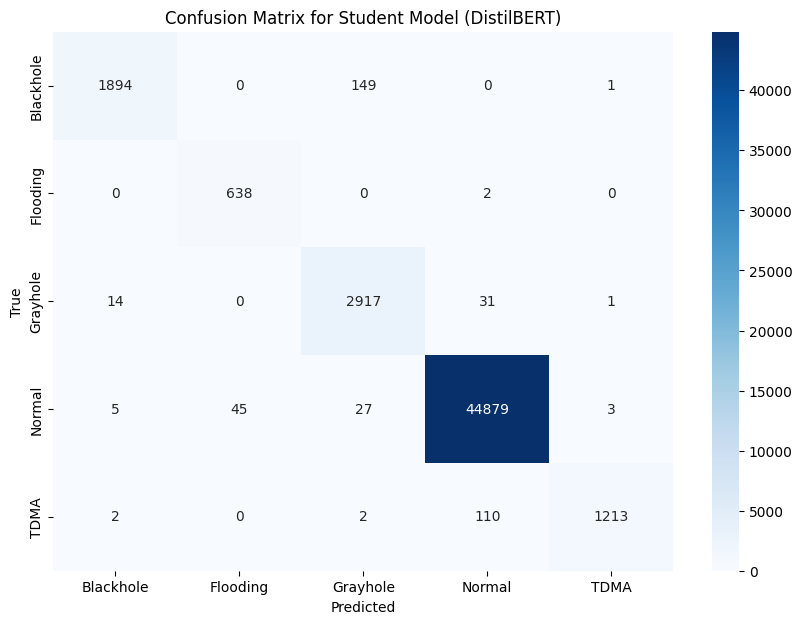

In [ ]:


# Plot confusion matrix for student model
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Student Model (DistilBERT)')
plt.show()



In [ ]:
from sklearn.preprocessing import label_binarize

# Plot ROC curves for student model
y_true_tensor = torch.tensor(y_true)
y_score_tensor = torch.tensor(y_pred)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

# Binarize the output for ROC calculation
y_test_binarized = label_binarize(y_true, classes=[i for i in range(n_classes)])
y_score = student_model(torch.tensor(X_test_tokens['input_ids'], device=device), attention_mask=torch.tensor(X_test_tokens['attention_mask'], device=device)).logits.cpu().detach().numpy()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Student Model (DistilBERT)')
plt.legend(loc="lower right")
plt.show()

# Summarize and plot accuracy
plt.figure(figsize=(10, 5))
accuracy_scores = [teacher_acc, student_acc]
models = ['Teacher Model (BERT)', 'Student Model (DistilBERT)']
plt.bar(models, accuracy_scores, color=['blue', 'green'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between Teacher and Student Models')
plt.show()

<ipython-input-23-7dd5a4d7d750>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_score = student_model(torch.tensor(X_test_tokens['input_ids'], device=device), attention_mask=torch.tensor(X_test_tokens['attention_mask'], device=device)).logits.cpu().detach().numpy()


OutOfMemoryError: CUDA out of memory. Tried to allocate 76.07 GiB. GPU 